In [1]:
# Run this only when using COLAB
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Run this only when using COLAB
% cd drive/MyDrive/moco

/content/drive/MyDrive/moco


In [3]:
# Import modules
from datetime import datetime
from functools import partial
from tqdm import tqdm
from PIL import Image
from pytz import timezone

from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.models import resnet

import argparse
import json
import math
import os
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from model_moco import CIFAR10Pair, SplitBatchNorm, ModelBase, ModelMoCo

In [4]:
# Parameters
parser = argparse.ArgumentParser(description='Train MoCo on CIFAR-10')
parser.add_argument('-a', '--arch', default='resnet18')

# lr: 0.06 for batch 512 (or 0.03 for batch 256)
parser.add_argument('--lr', '--learning-rate', default=0.06, type=float, metavar='LR', \
                    help='initial learning rate', dest='lr')
parser.add_argument('--epochs', default=200, type=int, metavar='N', \
                    help='number of total epochs to run')
parser.add_argument('--schedule', default=[120, 160], nargs='*', type=int, \
                    help='learning rate schedule (when to drop lr by 10x); does not take effect if --cos is on')
parser.add_argument('--cos', action='store_true', help='use cosine lr schedule')

parser.add_argument('--batch-size', default=512, type=int, metavar='N', help='mini-batch size')
parser.add_argument('--wd', default=5e-4, type=float, metavar='W', help='weight decay')

# moco specific configs:
parser.add_argument('--moco-dim', default=128, type=int, help='feature dimension')
parser.add_argument('--moco-k', default=4096, type=int, help='queue size; number of negative keys')
parser.add_argument('--moco-m', default=0.99, type=float, help='moco momentum of updating key encoder')
parser.add_argument('--moco-t', default=0.1, type=float, help='softmax temperature')

parser.add_argument('--bn-splits', default=8, type=int, \
                    help='simulate multi-gpu behavior of BatchNorm in one gpu; 1 is SyncBatchNorm in multi-gpu')
parser.add_argument('--symmetric', action='store_true', \
                    help='use a symmetric loss function that backprops to both crops')

# knn monitor
parser.add_argument('--knn-k', default=200, type=int, help='k in kNN monitor')
parser.add_argument('--knn-t', default=0.1, type=float, \
                    help='softmax temperature in kNN monitor; could be different with moco-t')

# utils
parser.add_argument('--resume', default='', type=str, metavar='PATH', help='path to latest checkpoint (default: none)')
parser.add_argument('--results-dir', default='', type=str, metavar='PATH', help='path to cache (default: none)')

'''
args = parser.parse_args()  # running in command line
'''
args = parser.parse_args('')  # running in ipynb

# set command line arguments here when running in ipynb
args.epochs = 50
args.cos = True
args.schedule = []  # cos in use
args.symmetric = False
args.moco_m = 0.99
args.moco_k = 4096
args.knn_k = 400
if args.results_dir == '':
    args.results_dir = './moco-history-' + datetime.now(tz=timezone('US/Eastern')).strftime("%Y-%m-%d-%H-%M-%S")

print(args)

Namespace(arch='resnet18', batch_size=512, bn_splits=8, cos=True, epochs=50, knn_k=400, knn_t=0.1, lr=0.06, moco_dim=128, moco_k=4096, moco_m=0.99, moco_t=0.1, results_dir='./moco-history-2021-07-29-22-59-13', resume='', schedule=[], symmetric=False, wd=0.0005)


In [5]:
# Load and prepare the data
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

train_data = CIFAR10Pair(root='data', train=True, transform=train_transform, download=True)
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, \
                          num_workers=16, pin_memory=True, drop_last=True)

memory_data = CIFAR10(root='data', train=True, transform=test_transform, download=True)
memory_loader = DataLoader(memory_data, batch_size=args.batch_size, shuffle=False, num_workers=16, pin_memory=True)

test_data = CIFAR10(root='data', train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False, num_workers=16, pin_memory=True)

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Creat the model
model = ModelMoCo(
        dim=args.moco_dim,
        K=args.moco_k,
        m=args.moco_m,
        T=args.moco_t,
        arch=args.arch,
        bn_splits=args.bn_splits,
        symmetric=args.symmetric,
    ).cuda()

# Model parameter counts
total_params = sum(p.numel() for p in model.parameters())
total_params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model.encoder_q)

ModelBase(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): SplitBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): SplitBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): SplitBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): SplitBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel

In [7]:
# Training setup
def train(net, data_loader, train_optimizer, epoch, args):
    net.train()
    adjust_learning_rate(optimizer, epoch, args)

    total_loss, total_num, train_bar = 0.0, 0, tqdm(data_loader)
    for im_1, im_2 in train_bar:
        im_1, im_2 = im_1.cuda(non_blocking=True), im_2.cuda(non_blocking=True)

        loss = net(im_1, im_2)
        
        train_optimizer.zero_grad()
        loss.backward()
        train_optimizer.step()

        total_num += data_loader.batch_size
        total_loss += loss.item() * data_loader.batch_size
        train_bar.set_description('Train Epoch: [{}/{}], lr: {:.6f}, Loss: {:.4f}'.format \
                                  (epoch, args.epochs, optimizer.param_groups[0]['lr'], total_loss / total_num))

    return total_loss / total_num

# lr scheduler for training
def adjust_learning_rate(optimizer, epoch, args):
    """Decay the learning rate based on schedule"""
    lr = args.lr
    if args.cos:  # cosine lr schedule
        lr *= 0.5 * (1. + math.cos(math.pi * epoch / args.epochs))
    else:  # stepwise lr schedule
        for milestone in args.schedule:
            lr *= 0.1 if epoch >= milestone else 1.
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [8]:
# Test setup
def test(net, memory_data_loader, test_data_loader, epoch, args):
    net.eval()
    classes = len(memory_data_loader.dataset.classes)
    total_top1, total_top5, total_num, feature_bank = 0.0, 0.0, 0, []
    with torch.no_grad():
        # generate feature bank
        for data, target in tqdm(memory_data_loader, desc='Feature extracting'):
            feature = net(data.cuda(non_blocking=True))
            feature = F.normalize(feature, dim=1)
            feature_bank.append(feature)
        # [D, N]
        feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
        # [N]
        feature_labels = torch.tensor(memory_data_loader.dataset.targets, device=feature_bank.device)
        # loop test data to predict the label by weighted knn search
        test_bar = tqdm(test_data_loader)
        for data, target in test_bar:
            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
            feature = net(data)
            feature = F.normalize(feature, dim=1)
            
            pred_labels = knn_predict(feature, feature_bank, feature_labels, classes, args.knn_k, args.knn_t)

            total_num += data.size(0)
            total_top1 += (pred_labels[:, 0] == target).float().sum().item()
            test_bar.set_description('Test Epoch: [{}/{}] Acc@1:{:.2f}%'.format(epoch, args.epochs, total_top1 / total_num * 100))

    return total_top1 / total_num * 100

# knn monitor as in InstDisc https://arxiv.org/abs/1805.01978
# implementation follows http://github.com/zhirongw/lemniscate.pytorch and https://github.com/leftthomas/SimCLR
def knn_predict(feature, feature_bank, feature_labels, classes, knn_k, knn_t):
    # compute cos similarity between each feature vector and feature bank ---> [B, N]
    sim_matrix = torch.mm(feature, feature_bank)
    # [B, K]
    sim_weight, sim_indices = sim_matrix.topk(k=knn_k, dim=-1)
    # [B, K]
    sim_labels = torch.gather(feature_labels.expand(feature.size(0), -1), dim=-1, index=sim_indices)
    sim_weight = (sim_weight / knn_t).exp()

    # counts for each class
    one_hot_label = torch.zeros(feature.size(0) * knn_k, classes, device=sim_labels.device)
    # [B*K, C]
    one_hot_label = one_hot_label.scatter(dim=-1, index=sim_labels.view(-1, 1), value=1.0)
    # weighted score ---> [B, C]
    pred_scores = torch.sum(one_hot_label.view(feature.size(0), -1, classes) * sim_weight.unsqueeze(dim=-1), dim=1)

    pred_labels = pred_scores.argsort(dim=-1, descending=True)
    return pred_labels

In [9]:
# Define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.wd, momentum=0.9)

# Load model if resume
epoch_start = 1
if args.resume is not '':
    checkpoint = torch.load(args.resume)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    epoch_start = checkpoint['epoch'] + 1
    print('Loaded from: {}'.format(args.resume))

# Logging
results = {'train_loss': [], 'test_acc@1': []}
if not os.path.exists(args.results_dir):
    os.mkdir(args.results_dir)
# dump args
with open(args.results_dir + '/args.json', 'w') as fid:
    json.dump(args.__dict__, fid, indent=2)

# training loop
for epoch in range(epoch_start, args.epochs + 1):
    train_loss = train(model, train_loader, optimizer, epoch, args)
    results['train_loss'].append(train_loss)
    test_acc_1 = test(model.encoder_q, memory_loader, test_loader, epoch, args)
    results['test_acc@1'].append(test_acc_1)
    # save statistics
    data_frame = pd.DataFrame(data=results, index=range(epoch_start, epoch + 1))
    data_frame.to_csv(args.results_dir + '/log.csv', index_label='epoch')
    # save model
    torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict(),}, args.results_dir + '/model_last.pth')

  0%|          | 0/97 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Test Epoch: [50/50] Acc@1:70.78%: 100%|██████████| 20/20 [00:03<00:00,  5.55it/s]


In [10]:
# Model parameters
print('Total model parameters: {}'.format(total_params))
print('Total trainable model parameters: {}'.format(total_params_trainable))

Total model parameters: 22468992
Total trainable model parameters: 11234496


<Figure size 432x288 with 0 Axes>

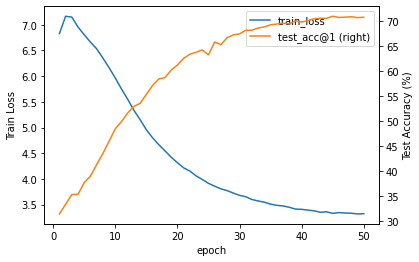

In [11]:
# Visualization of training history
df_history = pd.read_csv(args.results_dir + '/log.csv', index_col = 'epoch')

plt.figure()
ax = df_history.plot(secondary_y=['test_acc@1'])
ax.set_ylabel('Train Loss')
ax.right_ax.set_ylabel('Test Accuracy (%)')
plt.show()